In [193]:
#-*-coding:utf-8-*-
import pandas as pd
import numpy as np
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import tensorflow as tf
from numpy import ndarray
from sklearn.preprocessing import StandardScaler
import autokeras as ak



#만든 모듈을 불러옴
import sys
from importlib import reload
sys.path.append('Desktop/2021 AI 빅데이터팀/메탈 수요예측/code/') 
print(sys.path)
import Timeseries_module_ykkim as tsm

['C:\\Users\\KIMYEONKYOUNG\\Desktop\\2021 AI 빅데이터팀\\메탈 수요예측\\code', 'C:\\ProgramData\\Anaconda3\\python38.zip', 'C:\\ProgramData\\Anaconda3\\DLLs', 'C:\\ProgramData\\Anaconda3\\lib', 'C:\\ProgramData\\Anaconda3', '', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\KIMYEONKYOUNG\\.ipython', 'Desktop/2021 AI 빅데이터팀/메탈 수요예측/code/', 'Desktop/2021 AI 빅데이터팀/메탈 수요예측/code/']


<ipython-input-193-4f040845080b>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
data=pd.read_excel('C:/Users/KIMYEONKYOUNG/Desktop/2021 AI 빅데이터팀/메탈 수요예측/data/RawData_v1.3.xlsx')

In [134]:
column='RS1'
dd = tsm.ts_data(data,column)

In [196]:
scaler = StandardScaler()
scaler.fit(dd)
zdd = scaler.transform(dd)

# train,test split

In [197]:
train,test_nu=tsm.TS_holdout(zdd,5)

In [198]:
train_nu,test=tsm.TS_holdout(zdd,10)

# data preprocessing

In [199]:
# dateaframe to tensor
nd=np.asarray(train)
ndd=nd.reshape(len(train),)

In [200]:
def split_sequence(sequence:ndarray, n_steps:int)->(ndarray, ndarray):
    x = []
    y = [] 
    for i in range(len(sequence)):
        if(i+n_steps>=len(sequence)):
            break 
        x.append(sequence[i:i+n_steps]) 
        y.append(sequence[i+n_steps]) 
    return (np.asarray(x), np.asarray(y)) 


In [201]:
n_steps = 5
(x, y) = split_sequence(ndd, n_steps) 
print(x.shape) 
print(y.shape) 

(53, 5)
(53,)


In [202]:
n_features = 1 
x = x.reshape(x.shape[0], n_steps, n_features)
print(x.shape) 

(53, 5, 1)


In [203]:
# train(train,val)
# Hyperparameter Setting
BATCH_SIZE = 1
BUFFER_SIZE=1000

# Dataset -> Tensor
train_univariate = tf.data.Dataset.from_tensor_slices((x, y))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x, y))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

# LSTM model(univariate, simple)_train

In [204]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [205]:
path_checkpoint = "lstm_model_checkpoint_try3.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=100, mode='auto')# mode=auto loss면 최저값100번정도 반복되면 정지, acc면 최고값이 100번정도 반복되면 정지

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,)

In [206]:
# Build Simple LSTM Model
simple_lstm_model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(10, activation = 'relu', input_shape=(n_steps,1),return_sequences=True),#
    tf.keras.layers.LSTM(10, activation = 'relu', input_shape=(n_steps,1)), 
    tf.keras.layers.Dense(5),   
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse')


In [207]:
# # Train the Model
# # EVALUATION_INTERVAL = 30
# EPOCHS = 300

# history=simple_lstm_model.fit(x,y, epochs=EPOCHS,verbose=1,callbacks=[es_callback, modelckpt_callback]) #steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate,validation_steps=50,

In [208]:
# Train the Model(val)
EVALUATION_INTERVAL = 30
EPOCHS = 300

history=simple_lstm_model.fit(train_univariate, epochs=EPOCHS,validation_data=val_univariate,steps_per_epoch=EVALUATION_INTERVAL,validation_steps=10,verbose=1,callbacks=[es_callback, modelckpt_callback])

Epoch 1/300
30/30 [==============================] - 3s 18ms/step - loss: 1.0482 - val_loss: 0.4232

Epoch 00001: loss improved from inf to 0.88422, saving model to lstm_model_checkpoint_try3.h5
Epoch 2/300
30/30 [==============================] - 0s 6ms/step - loss: 0.7878 - val_loss: 0.4515

Epoch 00002: loss improved from 0.88422 to 0.71988, saving model to lstm_model_checkpoint_try3.h5
Epoch 3/300
30/30 [==============================] - 0s 6ms/step - loss: 0.8741 - val_loss: 0.4761

Epoch 00003: loss did not improve from 0.71988
Epoch 4/300
30/30 [==============================] - 0s 7ms/step - loss: 0.6402 - val_loss: 0.4971

Epoch 00004: loss improved from 0.71988 to 0.65733, saving model to lstm_model_checkpoint_try3.h5
Epoch 5/300
30/30 [==============================] - 0s 8ms/step - loss: 0.5933 - val_loss: 0.5034

Epoch 00005: loss did not improve from 0.65733
Epoch 6/300
30/30 [==============================] - 0s 8ms/step - loss: 0.7985 - val_loss: 0.5162

Epoch 00006: lo

In [209]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

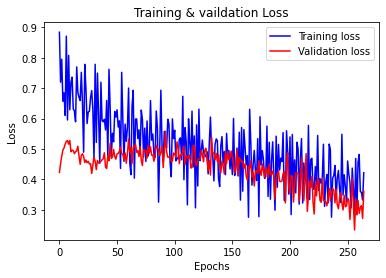

In [210]:
visualize_loss(history, "Training & vaildation Loss")

 # predict

In [216]:
ndt=np.asarray(test)
nddt=ndt.reshape(len(test),)

In [217]:
n_steps = 5
(xt, yt) = split_sequence(nddt, n_steps) 

In [218]:
n_features = 1 
xtt = xt.reshape(xt.shape[0], n_steps, n_features)

In [219]:
yhat = simple_lstm_model.predict(xtt)
prediction=pd.DataFrame(yhat)
prediction.columns=['predicted']
prediction.index=test[5:].index

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
# for inverse transformation
inversed = scaler.inverse_transform(prediction)
print(inversed)

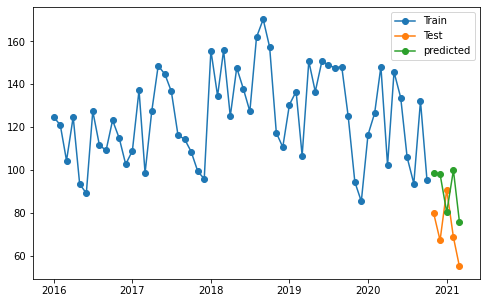

In [177]:
#graph
tsm.predict_graph(train,test_nu,prediction)

In [178]:
output=pd.merge(test[5:],prediction,left_index=True, right_index=True)
output

,RS1,predicted
Time,,
2020-11-01,79.923,98.401009
2020-12-01,67.150,98.040886
2021-01-01,90.721,80.252808
2021-02-01,68.630,99.880470
2021-03-01,54.973,75.798897


In [192]:
predd

,RS1,predicted
Time,,
2020-11-01,NaN,NaN
2020-12-01,NaN,NaN
2021-01-01,NaN,NaN
2021-02-01,NaN,NaN
2021-03-01,NaN,NaN


# metric(평가)

In [179]:
# MSE,RMSE
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(output['predicted'],output[column])
rmse=np.sqrt(mean_squared_error(output['predicted'],output[column]))
print('MSE (%s)'%mse)
print('RMSE (%s)'%rmse)

MSE (563.1153113214943)
RMSE (23.730050807393866)


# Plan, Predict 비교

In [184]:
plan=tsm.ts_data(data,'MS1')

In [185]:
compare=pd.merge(output,plan,left_index=True, right_index=True)

In [186]:
compare['pred_diff']=abs(compare['RS1']-compare['predicted'])
compare['plan_diff']=abs(compare['RS1']-compare['MS1'])

In [187]:
compare

,RS1,predicted,MS1,pred_diff,plan_diff
Time,,,,,
2020-11-01,79.923,98.401009,76.0000,18.478009,3.9230
2020-12-01,67.150,98.040886,55.0000,30.890886,12.1500
2021-01-01,90.721,80.252808,90.5325,10.468192,0.1885
2021-02-01,68.630,99.880470,78.5325,31.250470,9.9025
2021-03-01,54.973,75.798897,55.7140,20.825897,0.7410
